## Imports

In [1]:
import pickle

In [2]:
import torch
import torch.nn as nn

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
import gc

## Playground


#### Trying out nn.Flatten

In [5]:
m = nn.Flatten()

input = torch.randn(32,2,5,5)
output = m(input) # flattens from the dim 1 to -1 i.e (2,5,5)

output.size()


torch.Size([32, 50])

In [6]:
m = nn.Flatten(0,2)#flattens from the dim 0 to 2 (32,2,5)
output = m(input)
output.shape

torch.Size([320, 5])

Hence the flatten layer combines the elments along the axis start to end index

### Set the device

> This is the most important step!!

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load the tensors

In [8]:
def load_pickle(f_name):
    with open(f_name,"rb") as f:
        obj = pickle.load(f)
    
    return obj

In [9]:
train_text_tensors = load_pickle("/kaggle/input/converting-text-to-tensors-ipynb/train_text_tensors.pkl")

In [10]:
test_text_tensors = load_pickle("/kaggle/input/converting-text-to-tensors-ipynb/test_text_tensors.pkl")

In [11]:
train_labels_tensors = load_pickle("/kaggle/input/converting-text-to-tensors-ipynb/train_labels_tensors")

In [12]:
test_labels_tensors = load_pickle("/kaggle/input/converting-text-to-tensors-ipynb/test_labels_tensors")

## Custom Dataset and DataLoaders

In [13]:
class TextLabelDataset(Dataset):
    def __init__(self,text_tensor,label_tensor):
        
        self.text_tensor = text_tensor
        self.label_tensor = label_tensor
    
    def __len__(self):
        return len(self.text_tensor)
    
    def __getitem__(self,idx):
        return self.text_tensor[idx],self.label_tensor[idx]

In [14]:
train_dataset = TextLabelDataset(train_text_tensors,train_labels_tensors)

In [15]:
del train_text_tensors
del train_labels_tensors
gc.collect

<function gc.collect(generation=2)>

In [16]:
test_dataset = TextLabelDataset(test_text_tensors,test_labels_tensors)

In [17]:
del test_text_tensors
del test_labels_tensors
gc.collect()

63

In [18]:
#batch size of 32 is too large for kaggle mem, reducing it to 4
#if you are reducing the size of batch , also reduce the learning rate! because sgd will update after each batch. and since now the batches are small,hence more frequent updates,hence the lr should be less
train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)

In [19]:
del train_dataset
gc.collect()

0

In [20]:
test_loader = DataLoader(test_dataset,batch_size=4,shuffle=True)

In [21]:
del test_dataset
gc.collect()

0

In [22]:
##having a sneak at one train batch

for idx,data in enumerate(train_loader):
    text_tensor,label_tensor = data
    
    print(f"Shape of text tensor {text_tensor.shape}")
    print(f"Shape of label tensor {label_tensor.shape}")
    break

Shape of text tensor torch.Size([4, 16793])
Shape of label tensor torch.Size([4, 3])


## Building a Custom Model using Model parallelism

In [23]:
class TextClassification(nn.Module):
    
    def __init__(self,vocab_size,embed_dim,hidden_dim):
        
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size,hidden_dim,padding_idx=0) #output dim = batch_size*vocab_size*hidden_dim
        
        #now since our matrix has the embeddings of each word in the batch of the sentences and we need the embeddings of each sentence
        #hence we can flatten the last 2 dim
        self.flatten = nn.Flatten() # batch_size * (vocab_size*hidden_dim)
        
        self.gelu1 = nn.GELU()
        self.linear = nn.Linear(vocab_size*hidden_dim,32) #output dim = batch_size*32
        self.gelu2 = nn.GELU()
        
        
        self.final = nn.Linear(32,3)#output dim = batch_size*3
 
    def forward(self,text_tensor):
        output = self.embed(text_tensor)
        output = self.flatten(output)
        output = self.gelu1(output)
        output = self.linear(output)
        output = self.gelu2(output)
        output = self.final(output)
        
        return output

### Okay then! we can proceed with writing the training loop

##### But wait a min!! we still have bunch of things left to do

### Set the model to the current device i.e cpu or gpu

> note: we have already set the input tensors to the device

Check the length of the vocab 

In [24]:
vocab = load_pickle("/kaggle/input/converting-text-to-tensors-ipynb/vocab.pkl")
vocab_len = len(vocab)

In [25]:
model = TextClassification(vocab_size = vocab_len,embed_dim=512,hidden_dim=128)
model = model.to(device)


# Set the loss function:

Since we are dealing with a classification problem here , we will use cross entopy loss function
which basically calculates the entropy between the probability distribuition which is outputed by the model and the gold probability distribuition.

The more similar the probability distribution the less will the entropy i.e the loss

> Foumula for binary classification for a single instance
loss = -(p(gold output)*log(p(predicted output)) - (1-p(gold output))*log(1-p(predicted output)))

> The above can be be generalized for multiple classes
loss = -sum for each class(p(gold output)*log(p(predicted output)))


In [26]:
loss_fn = nn.CrossEntropyLoss()

# Set the optimizer

The optimizer decides how the gradient will be updated in backpropagation.Some of the commonly known optimizers are :

> 1) SGD : This is the same as mini batch gradient descent .w_new = W_old - grad_of_loss_wrt_w

> 2) SGD with momentum : Now SGD can get stuck it local minima,this borrows the intuition of momentum in physics, where the momentum due to previous gradient updates can push the parameter out of its local minima and lead towards global minima.  w_new = W_old + momentum, where momentum = function(grad_wrt_w_old, previous momentum)

> 3) Adagrad : Often times, using only momentum might be slow, as the gradients of many paprameters might tend to zero and not contirbute to gradient descent. Here we maintain the sums of squares of gradient and divide the learning rate of each paramater by the square root of the accualted sums of gradients for that particular parameter. Hence unlike momentum , different parameters will have different learning rates , which is better.

> 4) RMSProp : Since Adagrad uses squares of gradients, it can accumulate gradients too quickly and thus cause the learning rates to drop too rapidly. RMSProp thus handles the problem of Adagrad.

> 5) Adam : Adam basically combines the adavantages of momentum and rmsProp. With momentum it acheives the speed of convergence and with rmsprop every parameter gets to have its own learning rate.


In [27]:
#setting sgd with momentum
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)


In [28]:
def training_for_one_epoch(dataloader,epoch_nos):
    '''
        One epoch will do forward pass and backward pass for the model for the entire dataset for one iteration.
        For convergence, we would have do forward and backward pass multiple times for the dataset

    '''
    loss_for_the_epoch = 0
    
    #iterate through the dataset in batches, i.e we will at a time load the chuncks(of size = batch size) of dataset
    for idx,data in enumerate(dataloader):
        
        input_tensors,label_tensors = data
        
        input_tensors = input_tensors.to(device)
        label_tensors = label_tensors.to(device)
        
        #embedding layer needs the input to be of int
        input_tensors = input_tensors.to(torch.int)
        
        #label tensor required by the loss function is to be float
        label_tensors = label_tensors.to(torch.float)
        
        #refer to the notebook on autograd in the repository and recall how we calculate gradients.
        #optimizer will store the .grad value of all the parameters, hence at the start of our iteration, we will set the grads to 0
        #this is important, as we do not want to accumulate the gradients for each batch.
        #since we are doing sgd, we will update the gradients(via backprop) at the end of each batch and clear the gradients at the begining of each batch
        
        optimizer.zero_grad()
        
        #get the ouput of the model by doing forward pass
        model_output = model(input_tensors)
        
        #compute the loss
        loss = loss_fn(model_output,label_tensors)
        
        #now that we have the loss!, we would want to update all the parameters of our model by backprop
        #and recall this step from the autograd notebook as well
        #hence this step will calculate and update the .grad values of all the parameters in our model
        loss.backward()
        
        
        #and now that we have the gradient values of all our parameter, we would do gradient descent for the parameters. i.e upate the parameter values
        optimizer.step()
        
        loss_for_the_epoch += loss.item() 
        
        #print the loss for every 500th batch
        if idx % 1000 == 999:
            curr_loss = loss_for_the_epoch/1000 # loss per batch
            print('  batch {} loss: {}'.format(idx + 1, curr_loss))
    
    
    return loss_for_the_epoch/len(dataloader)
        
        
        
    

Code for Validation

In [29]:
def validate(dataloader):
    
    running_loss = 0
    
    for idx,data in enumerate(dataloader):
        input_tensor,label = data
        
        input_tensor = input_tensor.to(device)
        label = label.to(device)
        
        #setting the datatype of the tensors that the model expects. Certain layers say embedding layer, requires the tensor to be of a specific datatype
        #embedding layer needs the input to be of int
        input_tensor = input_tensor.to(torch.int)
        #label tensor required by the loss function is to be float as it expects logits
        label = label.to(torch.float)
        output = model(input_tensor)
        
        loss = loss_fn(output,label)
        
        #Hey! if you simply add loss and not loss.item() this causes a mem leak as the memory cannot be freed for the the next batch!
        running_loss += loss.item()
    
    return running_loss/len(dataloader)

## Wuhunn!! now we can actually train our model

lets have a sneak whether it actually works


In [30]:
## test forward pass for one batch
##having a sneak at one train batch

for idx,data in enumerate(train_loader):
    text_tensor,label = data
    
    text_tensor = text_tensor.to(device)
    label = label.to(device)
    
    text_tensor = text_tensor.to(torch.int)
    label = label.to(torch.float)
    output = model(text_tensor)
    print(output)
    loss_val = loss_fn(output,label)
    
    print("Loss",loss_val.item())
    break

tensor([[0.0813, 0.0543, 0.0033],
        [0.0815, 0.0485, 0.0060],
        [0.0819, 0.0523, 0.0058],
        [0.0829, 0.0458, 0.0073]], device='cuda:0', grad_fn=<AddmmBackward0>)
Loss 1.0819886922836304


In [31]:
from datetime import datetime

In [32]:
from tqdm.notebook import tqdm

In [33]:
num_epochs = 50
best_vloss = 1000000
best_model = None

list_of_train_loss = []
list_of_val_loss = []

for epoch in tqdm(range(num_epochs)):
    
    start_time = datetime.now()
    print(f"The Epoch number {epoch + 1}")
    
    ############ Training Mode ##############################3
    
    #setting the model to traning mode. Now, certain layers such as batchNorm and dropout behave differently in
    #in training and evaluation mode, hence this call helps to acheive it.
    model.train()
    
    avg_loss_for_batch = training_for_one_epoch(train_loader,epoch)
    list_of_train_loss.append(avg_loss_for_batch)
    
    ################ Evaluation Mode ####################
    #turns off dropout, batchnorm, adjusts the calculations
    
    model.eval()
    torch.cuda.empty_cache()
    avg_val_loss = validate(test_loader)
    list_of_val_loss.append(avg_val_loss)
    
    print(f"Validation loss for the epoch",avg_val_loss)
    
    #Saving the best model!
    if avg_val_loss<best_vloss:
        #clearly our model is performing better for test set now! 
        # this might be our best performance
        best_model = model
        best_vloss = avg_val_loss
        model_path = "model_{}".format(epoch+1)
        
        
    # if you are only going to use the saved model for inference save the state_dict() this does not save parameters,buffers,etc and thus saves space.
    #hoewever if you are going to use the model for fine tuning , do torch.save(model)
    
    #Save the final best model
    torch.save(best_model.state_dict(),model_path)
    
    
    
    end_time = datetime.now()
    
    print(f"Time take by the epoch {epoch + 1} is {end_time-start_time}")
        

  0%|          | 0/50 [00:00<?, ?it/s]

The Epoch number 1
  batch 1000 loss: 1.0660855302214622
  batch 2000 loss: 2.114125219464302
  batch 3000 loss: 3.1636332222819328
  batch 4000 loss: 4.210202537596226
  batch 5000 loss: 5.249041060864926
  batch 6000 loss: 6.276072546362877
  batch 7000 loss: 7.309770360469818
  batch 8000 loss: 8.337427041888237
  batch 9000 loss: 9.35395716804266
  batch 10000 loss: 10.378794834196567
  batch 11000 loss: 11.397775155723094
  batch 12000 loss: 12.411666133344173
  batch 13000 loss: 13.404989504933358
  batch 14000 loss: 14.39107644289732
  batch 15000 loss: 15.378611477226018
  batch 16000 loss: 16.35961835345626
  batch 17000 loss: 17.338641578912735
Validation loss for the epoch 0.9706103516676603
Time take by the epoch 1 is 0:05:04.565185
The Epoch number 2
  batch 1000 loss: 0.9431188066005707
  batch 2000 loss: 1.9043447607457638
  batch 3000 loss: 2.8614585027098656
  batch 4000 loss: 3.806080325126648
  batch 5000 loss: 4.75023053741455
  batch 6000 loss: 5.6938894682228565
 

## Plot the train and val loss

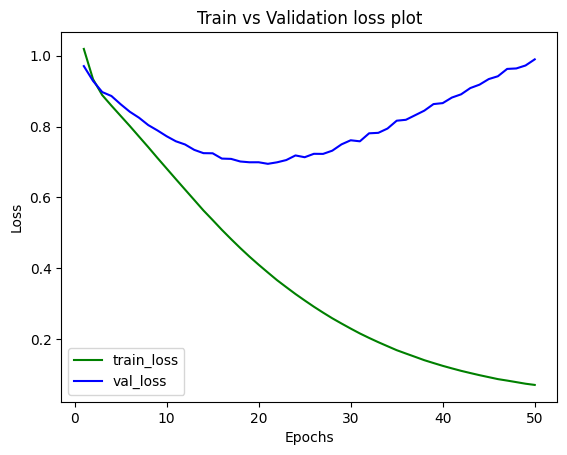

In [34]:
import matplotlib.pyplot as plt

x_axis = list(range(1,num_epochs+1))


plt.plot(x_axis,list_of_train_loss,color="green",label="train_loss")
plt.plot(x_axis,list_of_val_loss,color="blue",label="val_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation loss plot")
plt.legend()

plt.show()

## Woah! our simple model works quite good as we can see both the train and the val loss decreases steadily towards the start of the  epoch and with the increase in the epoch number the decrease is less steeper indicating that the model is tending towards convergence.

It might have helped to train it for further epochs, we could have also checked for convergence by setting a threshold.Where when the decrease in loss is less than that of the threshold, we can consider convergence.
